In [2]:

# !kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

100%|██████████████████████████████████████| 64.4M/64.4M [00:07<00:00, 10.9MB/s]
100%|██████████████████████████████████████| 64.4M/64.4M [00:07<00:00, 9.65MB/s]


In [9]:
import zipfile

zipref = zipfile.ZipFile("./data/cats-and-dogs-image-classification.zip")
zipref.extractall()
zipref.close()

In [1]:
import os

for dirpath, dirnames, filesNames in os.walk("data/cats-and-dogs-image-classification"):
    print(f"There are {len(dirnames)} directories and {len(filesNames)} images in {dirpath}")

There are 2 directories and 0 images in data/cats-and-dogs-image-classification
There are 2 directories and 0 images in data/cats-and-dogs-image-classification/test
There are 0 directories and 70 images in data/cats-and-dogs-image-classification/test/dogs
There are 0 directories and 70 images in data/cats-and-dogs-image-classification/test/cats
There are 2 directories and 0 images in data/cats-and-dogs-image-classification/train
There are 0 directories and 278 images in data/cats-and-dogs-image-classification/train/dogs
There are 0 directories and 279 images in data/cats-and-dogs-image-classification/train/cats


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "data/cats-and-dogs-image-classification/train"
test_dir = "data/cats-and-dogs-image-classification/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE, 
                                                         batch_size=BATCH_SIZE, class_mode="binary")


test_data_10_percent = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, 
                                                         batch_size=BATCH_SIZE, class_mode="binary")

Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [3]:
#  Create transorboard callback in a function

import datetime
import tensorflow as tf

def create_tensorboard_callback(experiment_name, dir_name="tensorboard"):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to: {log_dir}")
    return tensorboard_callback

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [5]:
efficient_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [6]:
def create_model(model_url, num_classes=10):
    """
    Takes tensorflow hub and create keras sequential model with it.
    """
    feautre_extraction_layer = hub.KerasLayer(model_url,trainable=False, # Freeze already learned patterns
                   name="feautre_extraction_layer",
                   input_shape=IMAGE_SHAPE+(3,)
                  )
    m = tf.keras.Sequential([
    feautre_extraction_layer,  
    tf.keras.layers.Dense(num_classes, activation='sigmoid',
                         name="output_layer")
    ])
    m.build([None, 224, 224, 3])  # Batch input shape.
    return m

In [7]:
efficient_model = create_model(efficient_url, 1)

2023-03-11 07:32:08.552500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-11 07:32:08.552648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2023-03-11 07:32:09.734896: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-11 07:32:09.735769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-11 07:32:09.995125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [8]:
efficient_model.compile(loss='BinaryCrossentropy',
               optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [9]:

efficient_history = efficient_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data_10_percent, 
                       validation_steps=len(test_data_10_percent), callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub", experiment_name="catsvsdogs")])

Saving Tensorboard log files to: tensorboard_hub/catsvsdogs/20230311-073216
Epoch 1/5


2023-03-11 07:32:19.049148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.8312

2023-03-11 07:32:28.156284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 14s 455ms/step - loss: 0.4753 - accuracy: 0.8312 - val_loss: 0.3762 - val_accuracy: 0.9071
Epoch 2/5
18/18 [==============================] - 6s 336ms/step - loss: 0.2478 - accuracy: 0.9551 - val_loss: 0.2744 - val_accuracy: 0.9286
Epoch 3/5
18/18 [==============================] - 6s 319ms/step - loss: 0.1692 - accuracy: 0.9713 - val_loss: 0.2196 - val_accuracy: 0.9571
Epoch 4/5
18/18 [==============================] - 6s 320ms/step - loss: 0.1306 - accuracy: 0.9749 - val_loss: 0.1962 - val_accuracy: 0.9571
Epoch 5/5
18/18 [==============================] - 6s 323ms/step - loss: 0.1056 - accuracy: 0.9838 - val_loss: 0.1727 - val_accuracy: 0.9643


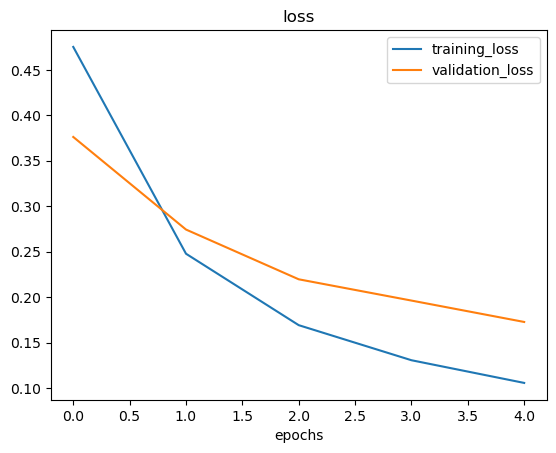

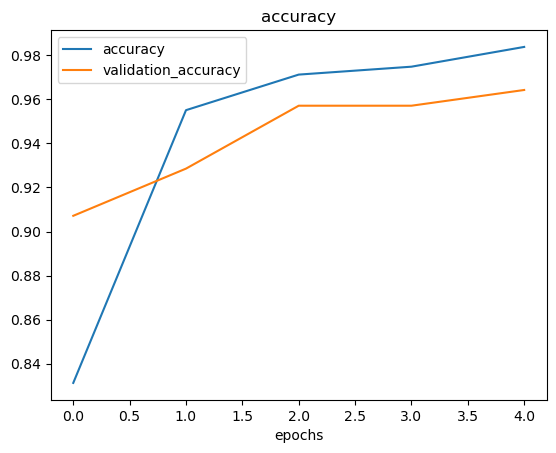

In [10]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="validation_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="validation_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_loss_curves(efficient_history)

In [12]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    
    img = tf.image.decode_image(img)
    
    img = tf.image.resize(img, size=[img_shape, img_shape])
    
    img = img/255.
    return img

def pred_and_plot(model, filename, class_names=["cats", "dogs"]):
    img = load_and_prep_image(filename)
    result = model.predict(tf.expand_dims(img, axis=0))

    if len(result[0])>1:
        pred_class=class_names[tf.argmax(result[0])]
    else:
        pred_class = class_names[int(tf.round(result))]
    
    plt.imshow(img)
    plt.title(pred_class)
    plt.axis(False)
    plt.figure()
    
import random
# pred_and_plot(efficient_model, "03-pizza-dad.jpeg", class_names)

2023-03-11 07:38:51.943050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


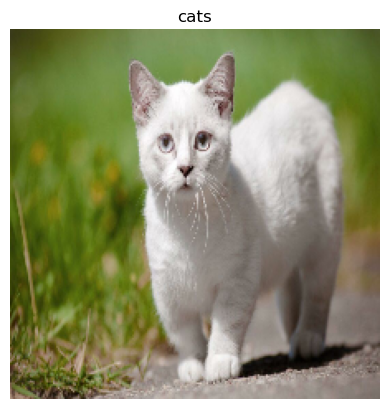

<Figure size 640x480 with 0 Axes>

In [13]:
import random

def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    
    random_choice = random.sample(os.listdir(target_folder), 1)
    
    
    pred_and_plot(efficient_model, target_folder + '/' + random_choice[0])



1/1 [==============================] - 0s 38ms/step


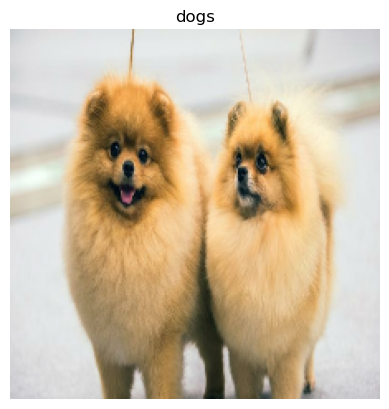

<Figure size 640x480 with 0 Axes>

In [93]:
img = view_random_image('./data/cats-and-dogs-image-classification/test/', 'dogs')